# UNKNOWN METRIC

In [1]:
%matplotlib inline
import sys,os
sys.path.append('/data/fragosta/work/lsst/sims_maf_contrib-master/')
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.stats import *
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.utils import equatorialFromGalactic, galacticFromEquatorial
from builtins import zip
from lsst.sims.maf.metrics import BaseMetric
from lsst.sims.maf.utils import m52snr, sigma_slope, astrom_precision

In [2]:
class propermotionmetric(BaseMetric):
    def __init__(self, metricName='propermotionmetric',U=np.arange(-400,400,25),V=np.arange(-600,200,25),W=np.arange(-400,400,25),m5Col='fiveSigmaDepth', mjdCol='observationStartMJD', 
                 filterCol='filter', seeingCol='seeingFwhmGeom', v = None, nexp= 1,dataout=True, detectSNR={'r':5,'i':5},
                 SedTemplate='flat', badval= -666,atm_err=0.01, normalize=False,baseline=10.,**kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.seeingCol = seeingCol
        self.nexp = nexp
        self.detectSNR = detectSNR
        self.mjdCol = mjdCol
        self.seeingCol = seeingCol
        self.m5Col = m5Col
        self.U=U
        self.V=V
        self.W=W
        self.atm_err = atm_err
        self.normalize = normalize
        self.baseline = baseline
        self.comment = 'Estimated uncertainty of the proper motion fit ' \
                       '(assuming no parallax or that parallax is well fit). '
        self.comment += 'Uses visits in all bands, and generates approximate ' \
                        'astrometric errors using the SNR in each visit. '
        if SedTemplate == 'flat':
            self.comment += 'Assumes a flat SED. '
        if self.normalize:
            self.comment += 'This normalized version of the metric represents ' \
                            'the estimated uncertainty in the proper '
            self.comment += 'motion divided by the minimum uncertainty possible ' \
                            '(if all visits were '
            self.comment += 'obtained on the first and last days of the survey). '
            self.comment += 'Values closer to 1 indicate more optimal scheduling.'
        self.v = v
        self.dataout = dataout
        # to have as output all the simulated observed data set dataout=True, otherwise the relative error for 
        # each helpix is estimated
        if self.dataout:
            super(propermotionmetric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol,self.seeingCol,"night"],metricDtype='object', units='', metricName=metricName,
                                                 **kwargs)
        else:
            super(transientsmetric, self).__init__(col=[self.mjdCol, self.m5Col, self.filterCol,self.seeingCol,"night"],
                                                       units='Proper Motion relative error', metricName=metricName,
                                                        **kwargs)
    # typical velocity distribution from litterature (Binney et Tremain- Galactic Dynamics)
    def DF(self,V_matrix, mode=''):
        U,V,W=V_matrix[:][0],V_matrix[:][1],V_matrix[:][2]
        if mode=='H':
            norm=0.02
            Va=200
            P=norm*np.exp(-((U/130)**2+((V-Va)/105)**2+(W/85)**2)/2)/np.sqrt(2*np.pi)/(130*105*85)
        elif mode=='B':
            norm=0.05
            Va=100
            P=norm*np.exp(-((U/120)**2+((V-Va)/95)**2+(W/75)**2)/2)/np.sqrt(2*np.pi)/(120*95*75)
        elif mode=='D':
            norm=0.98
            Va=10
            P=norm*np.exp(-((U/40)**2+((V-Va)/30)**2+(W/20)**2)/2)/np.sqrt(2*np.pi)/(40*30*20)
        return P
    
    # Likelihood Score function
    def L_score(self,c,f):
            bins= int((max(c)-min(c))*(len(c))**(1/3)/2.7/np.std(c))
            valuesC,binsC= np.histogram(c, bins=bins)
            valuesF,binsF=np.histogram(f, bins=bins)
            
            n=(valuesC*valuesF)**2*binsC[0:len(valuesC)]
            d=binsC[-1]-binsC[0]
            A= n.sum()/d
            
            return np.log(valuesC*valuesF/A)
    
    def run(self, dataSlice, slicePoint=None):    
        cexp, Lscore, vel, relerr=[],[],[],[]
        color,Mr, delta=[],[],[]
        outlier_cexp, Lscore_outlier, outlier_err, outlier_vel=[],[],[],[]
        #### photometric parallax ####
        idr = dataSlice['filter'] == 'r'
        idi = dataSlice['filter'] == 'i'
        rmag = np.random.rand(len(dataSlice[self.m5Col][idr]))*14+6
        rmag_err=m52snr(rmag,dataSlice[self.m5Col][idr])
        imag = np.random.rand(len(dataSlice[self.m5Col][idi]))*14+6
        imag_err=m52snr(imag,dataSlice[self.m5Col][idi])          
        nightr=np.unique(dataSlice["night"][idr])
        nighti=np.unique(dataSlice["night"][idi])
        # colors are estimated for the photometric parallax
        for iobs in nighti:
            for robs in nightr:
                if iobs==robs:
                    if rmag_err[np.where(nightr==robs)] >= self.detectSNR['r'] and imag_err[np.where(nighti==iobs)]  >= self.detectSNR['i']:
                        x=rmag[np.where(nightr==robs)]-imag[np.where(nighti==iobs)]
                        if x<2 and x>-0.2:
                            color.append(x)
                            Mr.append(3.2+13.30*x-11.50*x**2+5.40*x**3 -0.70*x**4) #Jùric et al. 2008
                        else:
                            continue
                    else:
                        continue
                else:
                    continue
        
        if len(Mr)>10:
            Mr=np.hstack(np.reshape(Mr, (len(Mr),1)))
            color=np.hstack(np.reshape(color,(len(color),1)))
            
            Mr_max= np.amax(Mr)
            rmag_max= np.amax(rmag)
            D_max= 10**(0.20*(Mr_max-rmag_max)+1)
            mu_max= 10**6*(1/D_max)**2 #km/s
            for s in range(self.nexp):
                M=np.random.choice(Mr)
                indM= Mr==M
                beta=np.random.choice(np.arange(0,2*np.pi, np.pi/10))
                
                #### velocity distribution###                
                mode=''
                f = np.random.rand()
                if f <=1/3:
                    mode='B'
                elif f>1/3 and f<=2/3:
                    mode='D'
                elif f>2/3 and f<=1:
                    mode='H'
                #position.append(f)
                V_matrix=np.vstack((self.U,self.V,self.W))
                v=np.zeros(len(V_matrix))
                vf = np.zeros(len(V_matrix))
                Pv=self.DF(V_matrix, mode)
                Pord=np.sort(Pv)
                row=np.where(Pv==np.random.choice(Pord[0:int(len(Pord)/2)]))
                
                for i in range(len(V_matrix)):
                    v[i]=V_matrix[i][row]
                    vf[i]=np.random.rand()*1000-1000
                   
                v = np.linalg.norm(v)
                vf= np.linalg.norm(vf)
                
                if f=='B' or f=='H':     
                    vT= v*np.cos(beta)
                    vfT=vf*np.cos(beta)
                else:
                    vT= v
                    vfT=vf
                
                mu= vT/4.75
                muf=vfT/4.75
                mags={}
                filters = np.unique(dataSlice['filter'])
                filters = [str(f) for f in filters]
                
                for f in filters:
                    mags[f] = M
                    
                precis = np.zeros(dataSlice.size, dtype='float')
                for f in filters:
                    observations = np.where(dataSlice['filter'] == f)
                    if np.size(observations[0]) < 2:
                        precis[observations] = self.badval
                    else:
                        snr = m52snr(mags[f],
                                              dataSlice[self.m5Col][observations])
                        precis[observations] = astrom_precision(
                            dataSlice[self.seeingCol][observations], snr)
                        precis[observations] = np.sqrt(precis[observations]**2 + self.atm_err**2)
                        
                good = np.where(precis != self.badval)
                sigma_mu = sigma_slope(dataSlice[self.mjdCol][good], precis[good])
                sigma_mu = sigma_mu*365.25*1e3  # Convert to mas/yr
                if (self.normalize) & (good[0].size > 0):
                    new_dates = dataSlice[self.mjdCol][good]*0
                    nDates = new_dates.size
                    new_dates[nDates//2:] = self.baseline*365.25
                    sigma_mu = (sigma_slope(new_dates, precis[good])*365.25*1e3)/sigma_mu
                if np.isnan(sigma_mu):
                    sigma_mu = self.badval

                if mu< mu_max: 
                    vel.append(vT)
                    relerr.append(sigma_mu/mu)
                    cexp.append(color[indM])
                else:
                    continue
                if muf< mu_max:  
                    outlier_vel.append(vfT)
                    outlier_err.append(sigma_mu/muf)
                    outlier_cexp.append(color[indM])
                else:
                    continue
            
            l=self.L_score(cexp,vel)
            l_outlier=self.L_score(outlier_cexp, outlier_vel)
            Lscore.append(l)
            Lscore_outlier.append(l_outlier)
            d=np.absolute(np.ma.masked_invalid(Lscore)-np.ma.masked_invalid(Lscore_outlier))
            print(d.sum())
            delta.append(d.sum())
            
        else:
            print('')
        
        
        if self.dataout:
            return{'rel_err':relerr,'out_err':outlier_err,'L_score':Lscore, 
                   'L_score_out':Lscore_outlier,'delta':delta}
        else:
            return np.mean(np.mean(outlier_err))
           
                


In [3]:
U=np.arange(-400,400,5)
W=np.arange(-400,400,5)
V=np.arange(-600,200,5)


In [4]:
listDBs= os.listdir('../DBs')
print('the available DBs are {}'.format(listDBs))
runName =input('insert the DB\' name: ')
opsdb = db.OpsimDatabase('../DBs/'+runName+'.db')
outDir = 'propermotion'
resultsDb = db.ResultsDb(outDir)
propids,probTags = opsdb.fetchPropInfo()
metric = propermotionmetric(U=U,V=V,W=W,m5Col='fiveSigmaDepth', mjdCol='observationStartMJD', filterCol='filter', seeingCol='seeingFwhmGeom', nexp= 500,dataout=True)
slicer = slicers.HealpixSlicer(nside=64)
sqlconstraint = 'filter="r" or filter="i"'
metricSky = metricBundles.MetricBundle(metric,slicer,sqlconstraint)
group = metricBundles.MetricBundleGroup({'metricSky':metricSky}, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()

the available DBs are ['baseline_v1.4_10yrs.db', 'baseline2018a.db', 'baseline_v1.4_10yrs.db.1', 'altLike_v1.3_10yrs.db', 'descddf_illum15_v1.3_10yrs.db', 'descddf_v1.4_10yrs.db']
insert the DB' name: baseline_v1.4_10yrs
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="r" or filter="i" for columns ['fiveSigmaDepth', 'filter', 'fieldRA', 'observationStartMJD', 'fieldDec', 'night', 'seeingFwhmGeom']
Found 953407 visits
Running:  ['metricSky']

























































































































































































































































































































































































































































































/home/enrico/SW/lsst_stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


5.472180588609648



































































































































































































































































































































































































































































13.32855313826233










































































































































































































































































































4.308437827920367







































































































































































































3.5025015515742375


7.412107785450413

5.729746435979434
2.869461658154407
5.536116901305547


5.359791607548319




5.130563704307589



1.8936037692649617


5.95804536175736



4.074557951085884


9.987074552711313
4.540644518728389
6.32391393149093


2.6618103815295378
5.844631708648555




3.785214807103573


7.300788963978636
7.5786815100201785
9.69352581635633
4.379396312151762
6.435263765721849



6.124013837189366
5.631454475112946

2.8370491132581837
6.804800252735337
3.5102899291855367
5.432840080516645
6.327834262039076
9.533158229734017

2.2711814712669005

4.045029775616918
11.303931173723207

7.093365175019477

5.1262237914408235
12.388636697355013
3.013653754342876
11.36984523418394

4.883068397857363
7.234136546054332
9.063233882365878
3.1881882968818935
5.959931233055443
10.1932757754597

8.96725022642206

4.706766703354889
1.9951568166663627



5.181764873767317


7.359967996963318



7.270029696234394
8.666343151703677
3.1932228727120666
5.507999328640032





3.335

8.293196073858995
9.516280874684862
8.280683868159707
4.975704655762449


5.314674409030328

4.979788087170059
7.508959994000747


8.510900183569625

8.166453280660196
7.192140372302186

6.074552676930486



4.309808629300415

3.9976303168281735
6.986242628039747

8.548313199582541

5.475880863652611
5.264308685158422








6.729315398585593

1.223733516565158



5.166961680315561


7.403875159657833

4.27588412654652
5.119500089958475
10.563523834064402
7.184791632972985
6.8018077453858865

5.114090734583103









6.161307960510586
3.931496192497173








7.09372392803653



7.695389725865406






8.111769996314914

4.837017643050325





5.638087064784896








4.902379113828015

3.057263613997101

8.149684883336434


6.093539423157678
7.439392622595857


12.881096515733137





4.570712563060841


13.622005178920825

4.273898482030328





3.291137935875396
7.346566409652118

4.78946805380672


7.210219278747331
8.116840698875594
9.06568612299469

6.71601187184452
6.754425

3.0226774209920286
5.35461588110746
11.580656604748716

5.189609961052934


8.325993184704359

5.232038425035537

5.706493446666228








10.79519069687449
3.3035804532846846

3.5284739978239106
8.000319133944537




11.327702945196899

8.845237768319906





10.455080551270177

5.204602383178846
8.862182217154167
12.402217575626814

9.519052474334169







7.3596008427155475

6.074876997260242
6.376961755088816

8.255891261514417




5.518503204820513
5.606594673720339
7.6862805983843305
4.768158627651603


9.282149692050629
5.6846652868496275
4.086339354850001
4.172869469463437


4.7344163384089



4.042913038071179

4.207056459303118
4.977808563049541
9.380264131821752


5.998104256835072

5.265552672679444

10.202509491957235

7.962873599613268




4.635849031090569
8.794041942963522
7.061693115475931



4.130359411037563







5.599379153959303

10.573921339250749





7.7984290844765525
1.353548520034071

11.768858926493122


7.144446953424087
5.589107477057624
9.661346392404

11.761448467008982
3.9755130409187043
6.738251372053604

7.967743584391499


5.109188118085829






7.337754615998593



11.285991558164866


8.413376658372442

7.624321951138734



2.9370870846909316






4.948857134843351



6.248355103299625
7.890508493362313
6.6662326133029275
5.547416396549737
9.523085445190315

6.604062946636686


5.208466319777248




6.9079560422064255
5.215123906437826


3.707156217986663


9.549781916383653



5.504600398521699







7.659600626104769

10.010242753733996
5.394445636722287

9.760160363587227




6.682619997428169



5.632022035442967
5.7132796286535505


9.12501004084314



9.590262488659521


3.8909806235909095

8.29222970899956

10.747821216735765
7.5457264214165285
3.980292277612314




7.410056741294509





2.795923487890933



10.11953344926758
5.764911467917948

3.410722070174499




7.277296032325642
8.392743803213685
6.390904753322522
7.949198150202802
4.882298656304549
3.576675215099238
7.669407719659564

6.12514038863582

4.93919

5.256927733842009

9.220604515686498
9.547261705328735

4.162908534847748
2.8683565511906153





11.052012694185535

5.907009262730238
7.736161163109845
5.221664162375582


4.974705033901179


6.947806010622781
5.5560378054388035
4.431349369400291

5.031904220474226


6.719603556856416

5.203720114174033



5.483409567193808



6.709781179089632
10.775408523342328

5.703582297520029
11.237713037950407
5.595459320889786



3.6290976487758773
5.144251832176192


5.333541945118652


12.181549779673311




7.194510832206467

5.0490777770153965

4.208177483475444
6.912112676762403



6.777508152482405
9.078663151140383





7.420157349577526
5.485785945210841

7.769151707485857
6.0983896430317674

4.31739206778607
4.6589987289942165
10.665669383139406




4.381512075167532
5.672149742352291
2.4247994348515434





3.831976059694295
10.241989336865084
5.839193336497017
3.4665641354652834
14.353512434585227

4.421935581957873

3.894745348260713
9.265422476938847


4.2610692564900345
3.734614

5.282713566479181



5.261746751421642
4.000385685576344
11.051442065492084
8.76320342249146
5.1181073891024536

9.211911856013598


6.569400776155447
5.307717141558003
4.418881172220422

4.600893204136083


3.546848735642964




9.84595182721283
7.474062218559791


3.685683267953827
7.436102922934021






2.8344053517993153






7.678214606004271
4.352673949659742



8.153711879116573






5.25942110384273
3.5200042131298908



3.4893842865526903
4.061022569923095



10.447852639336045





8.173498129278151

3.904375608649554
7.2835480959886265
4.0062994952481805






8.386069731114803

4.849157339853251
2.913903985405492


7.450322885292554


6.244988952019831

9.162727815711435

4.210535384472458
10.692605705510138
12.21431819710888












4.860977914457131
7.6178896029256595





4.562193339559888
3.2198042321674567




3.9997212472445334

3.4471959935319845


4.5989587938486265

10.3493523400239
5.424267978844414
8.487678003057798
5.755227171675861
4.127883254040023

10.

5.5003022682052745
4.902807825981288




5.039761465290518


6.237128122099147
7.128734853514736
7.738929363620116

2.398910186318963
12.419719331232669

8.290605822578293
3.4405647548461715
6.466225548151558

5.615192403017309


4.080882058749621
4.992020635464405
7.3652978648277205

10.419776965620494
9.706977487018104
6.407685358824686
3.729336807425751
9.62209825812779
4.955018653819918

6.303707523943459

5.413502976157558
6.39136628060635
5.447274533943434

6.164473411616504

7.090205112592793
3.466287284490461


3.659962890339175
8.429497561295655
8.125861359834742

6.489751769531596








4.555862381111757

4.237732824375506
3.9765756197955646







3.049703796465419


7.729256858943183
4.803536443155448
4.215747259766829






4.683943466935544








6.004512938176887






5.278411710519482






7.123239429565539
4.095387972499763




8.128158165389985
11.739296021241302
3.237402488705559
7.2378588850690715
7.295178794661895
4.208538632513648
4.796183617299587











3.5924675151463674


13.812943281965953

















3.66901251920741
3.9329169570348625
8.305664945815044
4.031592434029877


4.5978027346125625

5.9270367338400405
3.7288997161425517

7.876016747170615


7.675063270416501


3.652511809943059
3.666990184757948
2.8184548893738253
4.080635024131663
3.59659076595514
5.367486504383308

7.179931972672621
6.29248297031827

6.565830097664394

4.214338117634055
8.909538378444303

5.2225329322115
2.929609445159292
4.165250578287042
2.543061737101846
4.073140247866549

7.832705454329053
9.834079778993923

6.7967662708991075
4.727621711082895






5.0750088145782755
4.041484970366962



5.609537643186394

4.2354571712895215



10.348224590847906
7.8446325602421965






3.498447939207427




8.367469563628314
9.086004357986969








5.936586903268516


4.39064692757049
4.642906032985627
6.140301927010741



5.743623911260835

6.390034754412059


2.534261887848567
4.478149631092144

6.155581059775841

7.134372369246586


4.381949911318401


6.017168316056193
4.623776026514415



7.273750138164093
6.217210987873505

7.375653572413061
8.876932028560349


5.604641251932376
7.835542519529048
4.381724823024612


8.167134633961808
7.627618767261637
5.781190587636649

6.241981999080979
4.767366781379023

4.876781551652671

4.946627508183518

6.741242772623673
4.584715999695305



2.9868636902351104

8.748923321556221
















5.140515200031555
7.028336700067086
5.994540835625047

7.776440751693361


3.9757512144720675


7.8748756829909095

3.4510847482559317
2.79016917369027

6.674114778412768
9.37047610264007

4.811194895747002
6.430634382727092
6.36537602520686

6.412173996751372

7.957771668890498
3.5955207659149853
5.071076907769299
4.779622185378765
6.178281244922866

6.456409011175289
2.0263950849009458
5.464784025810101
5.069220937646271
3.3519266881619494

4.926520441408188
7.0255026286333955
5.200236109436094





8.207749168772905
11.9817267260933
5.440851905404918
3.8687543810553873
3.903034046922617




12.884

5.804274525785216

14.158599370937456
9.283202042770121
3.9635944278822457
2.8398174634684317
9.504915215127175

6.496234046860458

6.422388407672447



4.297915468616646
4.065703560383115

8.27080923298143
4.612935746742984
6.699851873184427
5.23500301247384
5.273677634431953
6.5023540881298665


5.628024799296604
3.9466394117175287




6.224408494507379
3.2882665357862884















5.091256859971697
4.814100828661934
6.074287097276793

6.7380546216027035

7.721423141582276
8.643637785310771
5.657510812706471


2.761029573261414
7.213037597957467
5.023670838647991
5.458702625519679
8.396342432540527
5.840410560655194
6.384475690404379
4.846536795523599
5.719746622273449


8.100208068433881
6.953838650509375
7.021999738344855
4.232823981046765
7.029999337122973
5.472907092725629
9.097216460428244
12.433894793132849
4.169222290819732


7.297379851936977

5.820133001507903
2.568855112915827



10.315232000757979
5.7211149287614
5.988123637685396
5.393594689870702
7.813129641070331
5

6.186713387650926
4.936361840836591
8.917483226253369
6.51691063247479
10.95844146954027
2.786134681575289


3.6563290928156853

3.773090019850578


5.606597509776824
3.601340456273384





3.851200144045926


5.433575243056207
10.005986136500047
9.371274450682279
15.276571906422337
5.5957203570855185
9.16408342377432

7.367010950879099


8.366659746525555

3.59635048855346
7.089375156995846

6.640664962246779

13.084270461275237


5.863912456152036
9.806731434348999

2.6149849279711486

















6.650212853722911
3.3595915284584823


6.4216792264358045
5.770008646469611

6.384178599231408
5.996269266540969
7.606943723964832
6.031634017930868

3.0394478652044743
12.074981510404207

7.332484119873643
8.769495351962803
6.498283802146453
3.4110532189103306
6.49919444844965

4.269364357601603
7.417740946209818
5.864051495817977
3.3403985820211712

7.638660186377031
3.864004780985276
11.414955230591051
10.191949158752811
9.178553633107477
5.689493090749206

3.1702360275058226
6.76199

4.600456748455443
1.8517298423364803



4.401193215137706

10.4314729160235
5.79973795364813
4.128892332667432


4.600906150371523



4.27635742259281
7.462876686597495

8.635728471861729
8.118102297024349
3.058630882324529


3.8626602256748033
4.456734253398707

















7.23801409786658
5.820631200702707
8.40775976794294

9.36191364023215
13.06475686063457
7.483170824155014
4.887996425566142





9.465272831032383
3.969923915576345

8.508008313603993
9.61141968745005
3.696550850869359
4.1260722130649246
3.7084530787618775
5.302628314276337


7.915032453492419
4.329921190597643
2.269590618215492
3.2226367017118616
7.196440049829631
8.067275726093415
4.926408582348595
5.902393419094025
6.260757252256463

4.855117633176771


4.683197834552216
3.809652167923195
4.2516061200091375
7.580032217532882

12.675547076167703

7.346563572884287
6.656739723017104
10.535215232292533
3.46313187505198


2.963282453627201
3.052487985939277
5.23882834747981
4.794602745749803


9.356797121008956


4.660640767246571
6.436898361970092
5.3368187981571396
9.509510279866106
5.795048968581698

4.029094437308073
7.131455891605986


4.501782141450253


6.424098454753368

6.883027608508545



5.840045432007516
5.6062043020141346

2.7833782421662114
7.2684199970907315
4.280255297601565

4.8232094752407075
3.739502201598853
1.5168397515560166
6.78229796609247

4.300872006223507
4.6852139384678715

10.134549141466792


14.120540987561167
4.009071155018487

12.395553185187937






5.394832448011227




4.37950344671175









4.806551704533293



4.046883796408327





4.009080118279252
10.25279772800051
7.727481239889144


7.194410016917088



3.4782876124414805





4.5588476972564465
10.245240244803147

5.455807761457335

10.06166098431813
5.872985467178751

3.018751949647056



2.786217568184572



5.539544930193465











8.15036468868949

6.872174027956833
10.172163314035716


4.721665586013694
2.607149568643182
4.290883020891631
7.301971232667418




3.5426256549828086

10.4812

6.829394528175225
3.2924905240849007
8.332960015706645
5.049296611230993




3.979788473056839
4.77542276701892


7.817392104544805
6.626001923847632


3.7267720789569356



11.066116534671647
4.422769663137348
3.579309437212439
5.361515522078305

4.50105267127722
4.545702018189038

7.338166237150457



4.36398207307659


4.939157486444719













2.965565437232822
2.018242374878259

6.4811314618753695



4.43739121094756
8.423838747172129



5.2758769309369615

11.953877711472865





9.198672552789814

6.978533024704104



2.9162977223463873
5.528518738256681




5.7946307853756664
4.211796906409649
7.203519168763611




5.708864929624358




6.010040138932167
4.13285647609904








12.764546798848635
10.973814214973855
2.9661294417245543


4.8754584794657685




9.149766193293194

5.8034802182400025
3.687716686596552
12.015175431643978

5.745556163896106
5.626887704329771
7.096652972758049



9.615071016052907

3.7634177780841114

2.3044774373168213
12.231541983688125

5.6917

7.381111702981556





4.530517468207076






6.26032597385222




7.778634176970689
4.2815118428470935


4.158709269665458
10.469823130362345

3.4198410792428113


7.613665797027913
3.2860828471647476



















7.775446282449231


4.58783715047937

11.966126356263853

9.397380082626805


10.583700488405924


5.196457992509512

9.843717165485204

7.444380182722405
7.813053349462759
6.5407937661597675
6.232579913255572
5.18944454451584

9.446688957903904
12.002493275193453

5.359267584635907


14.88874354406103
4.067768655929099
5.960907464058186
5.891101962090005
5.565871448530929

7.64567178094755
8.500064003351815

3.299536667223185
2.5053927065269743
7.690126058376125

7.311869276414939


5.497809265260436


7.194871710062287

10.27761812143981
5.399022073603728

7.241817881561161
4.472869359273362





4.939988941368036
12.342289324997566
4.4819166102484385
6.982838938916149





4.689934385742607
3.7643229509116143




6.815282720204676




4.148500048391188


8.04845506

5.333272005719188

7.33237492088222

8.818531609453597
7.7393265298562905
4.435793235673994

3.569798260774901

5.3331445225847
4.725203086969085
12.103181485925713
3.642942956245431
5.90841698410401
11.652290933925238




6.196819405903529
9.639790536000403
3.0342783998226057


2.7440180065416495

4.505469472644053


4.051030422891813
3.573664138065924
4.856896256222342





6.618311185499715
8.008220661718529
6.104269174700443
6.856770430758193
4.821884581334237














12.915192547561709




6.4492120096188135



5.9968089090051855





5.6338294881122355
5.369285241733641
11.742636921929686

5.27851030716128
6.340369390514535



4.015812569812972
4.255022720534459


9.746212170859183


9.887692019971277






2.9573142315354097
12.596486223850548




3.8967505031634584










4.708263464897405





4.458142805884593


3.149878659764191



7.14214133308009


3.94203059145428

3.353908858511838
3.278398368102623
6.8251399431006465
4.0083722388376835

4.8290586792520624

4.20

12.448450766820782

8.688245325407177


4.90268211062129


6.192098581766052
7.495533912011325

6.14064177259236


8.857158171421755
4.724511917872217



9.622596747351679


6.07491035831924

6.4240633456166165
6.540480428572021

6.293188097298069

9.344378482157369

3.12107576860242



8.192764044711742
8.181702253280008


8.567445799140689





6.157740933342556







4.432605007502817



5.4373210786516815




3.246150467003079
6.0003164303219005
7.201019729013646
4.91945999941122
5.627548304452196


5.93738725740211
4.432813418946671
6.95730644843003
6.530995458286901

4.079275001914505



6.110532297798999
2.715955760904629
15.465217850860848

5.375700389256291

5.047052706471019

4.064224572666433
6.045923454451003

6.770135133428267


2.085699169671841



3.512821257520308
16.282815157590335
3.898684654836595

8.296510127956658
3.8234069291663726
5.187544527030289
5.19653483018563




















3.842286660023083
15.09801380558454

6.606601646563723




6.5282114724003755


5.787591235014769
6.672840355979622



16.895287568494837





















8.070984408401397
7.96499450469787
8.890284150190144

4.490571607135857
5.3692454644701755
9.460874083356678
6.644997307580363
7.195255826975027

6.346102745034713
5.660022428631292

6.252068815520666

5.71216373151719

8.084834532282578

3.847225147639559

8.665419672277233


7.159205355487458

5.96698411677931
7.189221831831306

2.4789167345494683

7.230934081959283




6.339912204007261
6.947336801162475
6.317173685616556
8.366016869586613
3.2508188199368515
4.953095232441848


4.885159171481535
5.569850188031607
7.291443751452576

7.5569437411898495
6.125170648945627
7.137156627223808

4.636318482347434

6.524166427692673
5.915281961134273
10.44194409104713

7.963977045135641

6.842813821113923

6.0286637201600275
5.8428702886441
5.991865089238004


3.6355237449883067
6.00550688677642
7.65521036617155
9.158001039604208
9.965278395409772









7.005844333555263











8.121445596495231


8.82625787

7.067074783837276

4.877373819799207


4.5946094307276155
3.851276596705649
2.4323696468176994


3.2538331421429554

4.166255004030882
3.3829330662334076
6.470738501407617
2.659017533311486
10.649748253019542

9.560399430741336


























6.389467162894023

6.66849941125697
4.7219921145159205
9.553879887446971
8.403283720767035
3.777959195332423
9.101671120540159
2.458895821229996
4.834375328680897
11.94112101214675
8.762231233595712
6.243014161719961
3.9645761225677605

3.417981873422156
5.264728693425015
7.992070392317844
8.845983891576266

6.177485937048846
5.04687053789951
5.347552843158649
10.624745574425514



6.997141082122505

8.957821793647906

4.941382927991336
9.210693767050644
6.239035241423666
5.548407819691633
8.54025959209312
12.550420349493459
3.992025207027739
3.5003009899814046

13.348121978784215
5.932430824352437
3.790415855189474

4.087077883735322
3.7509456796814664
3.6219078516512404
5.669837813987662
9.991496198337286
6.418955867656452
3.379957940

6.667737708908385
3.47651842926261

10.271739581771211







7.430742013148512

7.148471218368467


3.6239002192845984
11.216364063636679
5.225955223663767

4.841012175074322





4.21340576193383
6.363708357555852
3.4134529651703254












4.621839333281844


5.254618335202064


6.28394845587515
4.346605195862184






5.27497580370575

15.399830832945375



4.618773212740457
2.7334783722242957



4.495652048513744
6.745549800745497




9.382399261145608




7.963766850868362



6.275906119404167





3.3366494931015325
4.221813884718278
3.9029165322313695

3.7165416993405795



11.582949797550784


7.360092914538058
4.8304950565031675
3.294591781281772
6.561840652702934

10.960409087867152



6.191476016312769
8.376819386934384
5.1551821885002145
7.324278167935953


5.047645266060137

5.597127409976496

5.326160306567294



6.403771560176159
3.7127610116329475

3.3524047165265944
6.07112530303735
6.052214418314248
3.6845955721117463
6.987756399896693
6.6731539431387805

12.3582

4.849579975207416

13.541829351312568

14.090244468800105


9.284518209793553
5.572570336659727
4.674309614222462
2.921340601352412
6.694960655803515
12.535840386100656
5.09416753221292

3.9675824134522735




6.442240856272603
10.426025156248576






7.976645619500458




7.429863931983485

4.5979218356008875

4.584118351800228






7.590791585732054
5.2218716743260565


3.2066452549673503












3.945989554991419

6.973560544779515



6.710585906210751




12.790658188523635
4.375263130088445
5.40482171793899


5.7327030088490005




4.350289307446653
8.200824549523832


6.3231254331417475
4.586765132634618

10.296372986435648


6.103383527313454




5.690811251223087
5.1160293585168475


2.440199681052249






4.248592461279598
9.517517167097003

9.226456449784939
8.755281796425033
8.52402742622158
5.800118608454989
13.0197889002684

7.476938836168657
5.031180789106346
2.5511606183541335
12.361536424070144

3.67412503194182


6.501803455891761
5.380891656505444
7.14673938225

5.18594435023118
4.814042131737374


7.052208954006419
14.094971256105394
4.489045401092946

11.14299266033313
10.680466675194568
6.577645618882951






9.705500315714298
5.229385441132145
9.112450994989112
3.634963723132973
6.984141581487638
2.9115375039325464


5.980663162941804

5.775303384373187
3.5435004184421572
6.940031263722274

8.374920556653592
























6.890354094420109
8.461838298609607
7.009903144350684
1.7812223236403781
10.614422409053557
5.367632576339572

6.031392949259599


6.0894926310260855
7.4157488599887635


8.79391038395204
9.355862109649735

6.654457093344568
6.32306551275952

7.1459405100637365
8.27786380551923

7.27731928656768

8.090416769925437



5.536105258325821




7.885018512691369
5.141831815896493

4.395931196116141

3.390679694738422
3.947661738811565
3.767353124424715
7.057895139179337
5.293187075607809
5.812579418586811


4.747673338995545




2.7350320039312717



6.570441644510151

8.296394670966402




2.5180578791544885






5

5.548406204127836
7.587081387542167

5.007539469339061
5.653386118637254

5.5144915040767355

7.357728359539834
8.563147202661607
6.602251735790256

















3.8027213029715625






7.707459157498789








7.409638114545617









10.646317718978324






6.625983788173086

3.1382959666510892


3.417425460516805



8.784601648406495
9.770637329569475
8.219974063462601



3.8256451454740397
4.250782148470355
14.497137309382282








































2.5012427931611168


3.3683820249016003


4.690166280502638

4.785065371521398


11.27566239823666


5.527004141198084
3.6211119968089687
6.372670653104393


5.603016725533777
4.996931003564402
11.683516641867591
5.458942015964432


3.3773063108016164


9.227133638452349








7.594849602224176
9.28625462611761
5.072234241256867
8.902046196634744

5.141192693595983

















































































































12.325994195970532


















In [5]:
data=pd.DataFrame(metricSky.metricValues[np.where(metricSky.metricValues.mask == False)])

In [7]:
rel_mu = []
delta = []
lscore=[]
for i ,d in enumerate(data[0]):
    if d['rel_err']:
        rel_mu.append(d['rel_err'])
        delta.append(d['delta'])
        lscore.append(d['L_score'])
    else: continue
    

In [8]:
out_err, out_score=[],[]
for i ,d in enumerate(data[0]):
    if d['out_err']:
        out_err.append(d['out_err'])
        out_score.append(d['L_score_out'])
        #position.append(d['position'])
    else: continue

In [9]:

out_err=np.hstack(out_err)
out_score=np.hstack(out_score)


In [10]:
delta=np.hstack(delta)
rel_mu=np.hstack(rel_mu)
lscore=np.hstack(lscore)

In [11]:
def bayesian_blocks(t):
    """Bayesian Blocks Implementation

    By Jake Vanderplas.  License: BSD
    Based on algorithm outlined in http://adsabs.harvard.edu/abs/2012arXiv1207.5578S

    Parameters
    ----------
    t : ndarray, length N
        data to be histogrammed

    Returns
    -------
    bins : ndarray
        array containing the (N+1) bin edges

    Notes
    -----
    This is an incomplete implementation: it may fail for some
    datasets.  Alternate fitness functions and prior forms can
    be found in the paper listed above.
    """
    # copy and sort the array
    t = np.sort(t)
    N = t.size

    # create length-(N + 1) array of cell edges
    edges = np.concatenate([t[:1],
                            0.5 * (t[1:] + t[:-1]),
                            t[-1:]])
    block_length = t[-1] - edges

    # arrays needed for the iteration
    nn_vec = np.ones(N)
    best = np.zeros(N, dtype=float)
    last = np.zeros(N, dtype=int)

    #-----------------------------------------------------------------
    # Start with first data cell; add one cell at each iteration
    #-----------------------------------------------------------------
    for K in range(N):
        # Compute the width and count of the final bin for all possible
        # locations of the K^th changepoint
        width = block_length[:K + 1] - block_length[K + 1]
        count_vec = np.cumsum(nn_vec[:K + 1][::-1])[::-1]

        # evaluate fitness function for these possibilities
        fit_vec = count_vec * (np.log(count_vec) - np.log(width))
        fit_vec -= 4  # 4 comes from the prior on the number of changepoints
        fit_vec[1:] += best[:K]

        # find the max of the fitness: this is the K^th changepoint
        i_max = np.argmax(fit_vec)
        last[K] = i_max
        best[K] = fit_vec[i_max]

    #-----------------------------------------------------------------
    # Recover changepoints by iteratively peeling off the last block
    #-----------------------------------------------------------------
    change_points =  np.zeros(N, dtype=int)
    i_cp = N
    ind = N
    while True:
        i_cp -= 1
        change_points[i_cp] = ind
        if ind == 0:
            break
        ind = last[ind - 1]
    change_points = change_points[i_cp:]

    return edges[change_points]

In [12]:
lscore = lscore[~np.isnan(lscore)] 
good= (lscore!=-np.inf) 
lscore=lscore[good]

In [13]:
out_score = out_score[~np.isnan(out_score)] 
out_good= (out_score!=-np.inf) 
out_score=out_score[out_good]

In [14]:
bins_lscore=bayesian_blocks(lscore)
bins_outscore=bayesian_blocks(out_score)

In [16]:
bandwidth=0.2
kde_skl = KernelDensity(bandwidth=bandwidth)
kde_skl.fit(lscore[:, np.newaxis])
# score_samples() returns the log-likelihood of the samples
log_pdf = kde_skl.score_samples(bins_lscore[:, np.newaxis])
pdf=np.exp(log_pdf)

/home/enrico/SW/lsst_stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log


In [14]:
bandwidth=0.2
kde_skl = KernelDensity(bandwidth=bandwidth)
kde_skl.fit(out_score[:, np.newaxis])
# score_samples() returns the log-likelihood of the samples
log_pdf_out = kde_skl.score_samples(bins_outscore[:, np.newaxis])
pdf_out=np.exp(log_pdf_out)

(0, 1)

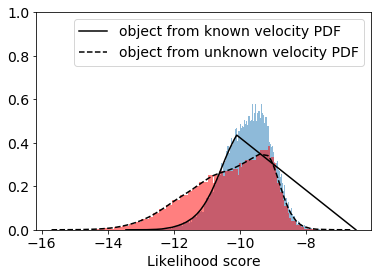

In [39]:
plt.figure()
plt.plot(bins_lscore,pdf,'k-', label='object from known velocity PDF')
#plt.hist(lscore,bins=bins_lscore, density=True, alpha=0.5)
plt.hist(lscore,bins=500, density=True, alpha=0.5)
plt.plot(bins_outscore,pdf_out,'k--',label='object from unknown velocity PDF')
plt.hist(out_score,bins=bins_outscore, density=True, color='red',alpha=0.5)
plt.legend()
plt.rcParams.update({'font.size':14})
plt.xlabel('Likelihood score')
plt.ylim([0,1])

Text(0, 0.5, '$(\\frac{\\sigma_{\\mu}}{\\mu})_{\\quad unknown\\quad vel\\quad PDF}$')

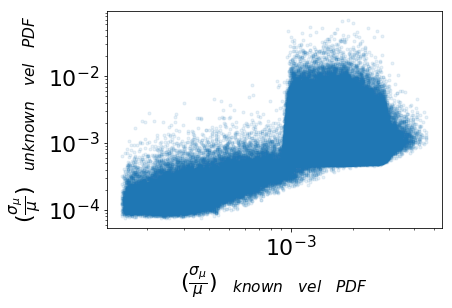

In [43]:
plt.figure()
plt.plot(rel_mu, out_err, '.',alpha=0.1)
plt.yscale('log')
plt.xscale('log')
plt.rcParams.update({'font.size':22})
plt.xlabel(r'$(\frac{\sigma_{\mu}}{\mu})_{\quad known\quad vel\quad PDF}$')
plt.ylabel(r'$(\frac{\sigma_{\mu}}{\mu})_{\quad unknown\quad vel\quad PDF}$')


In [46]:
def scatter_contour(x, y,
                    levels=10,
                    threshold=100,
                    log_counts=False,
                    histogram2d_args=None,
                    plot_args=None,
                    contour_args=None,
                    filled_contour=True,
                    ax=None):
    """Scatter plot with contour over dense regions

    Parameters
    ----------
    x, y : arrays
        x and y data for the contour plot
    levels : integer or array (optional, default=10)
        number of contour levels, or array of contour levels
    threshold : float (default=100)
        number of points per 2D bin at which to begin drawing contours
    log_counts :boolean (optional)
        if True, contour levels are the base-10 logarithm of bin counts.
    histogram2d_args : dict
        keyword arguments passed to numpy.histogram2d
        see doc string of numpy.histogram2d for more information
    plot_args : dict
        keyword arguments passed to plt.plot.  By default it will use
        dict(marker='.', linestyle='none').
        see doc string of pylab.plot for more information
    contour_args : dict
        keyword arguments passed to plt.contourf or plt.contour
        see doc string of pylab.contourf for more information
    filled_contour : bool
        If True (default) use filled contours. Otherwise, use contour outlines.
    ax : pylab.Axes instance
        the axes on which to plot.  If not specified, the current
        axes will be used

    Returns
    -------
    points, contours :
       points is the return value of ax.plot()
       contours is the return value of ax.contour or ax.contourf
    """
    x = np.asarray(x)
    y = np.asarray(y)

    default_contour_args = dict(zorder=2)
    default_plot_args = dict(marker='.', linestyle='none', zorder=1)

    if plot_args is not None:
        default_plot_args.update(plot_args)
    plot_args = default_plot_args

    if contour_args is not None:
        default_contour_args.update(contour_args)
    contour_args = default_contour_args

    if histogram2d_args is None:
        histogram2d_args = {}

    if contour_args is None:
        contour_args = {}

    if ax is None:
        # Import here so that testing with Agg will work
        from matplotlib import pyplot as plt
        ax = plt.gca()

    H, xbins, ybins = np.histogram2d(x, y, **histogram2d_args)

    if log_counts:
        H = np.log10(1 + H)
        threshold = np.log10(1 + threshold)

    levels = np.asarray(levels)

    if levels.size == 1:
        levels = np.linspace(threshold, H.max(), levels)

    extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

    i_min = np.argmin(levels)

    # draw a zero-width line: this gives us the outer polygon to
    # reduce the number of points we draw
    # somewhat hackish... we could probably get the same info from
    # the full contour plot below.
    outline = ax.contour(H.T, levels[i_min:i_min + 1],
                         linewidths=0, extent=extent,
                         alpha=0)

    if filled_contour:
        contours = ax.contourf(H.T, levels, extent=extent, **contour_args)
    else:
        contours = ax.contour(H.T, levels, extent=extent, **contour_args)

    X = np.hstack([x[:, None], y[:, None]])

    if len(outline.allsegs[0]) > 0:
        outer_poly = outline.allsegs[0][0]
        try:
            # this works in newer matplotlib versions
            from matplotlib.path import Path
            points_inside = Path(outer_poly).contains_points(X)
        except:
            # this works in older matplotlib versions
            import matplotlib.nxutils as nx
            points_inside = nx.points_inside_poly(X, outer_poly)

        Xplot = X[~points_inside]
    else:
        Xplot = X

    points = ax.plot(Xplot[:, 0], Xplot[:, 1], **plot_args)

    return points, contours


In [68]:
lrel=np.log10(rel_mu)
lerr=np.log10(out_err)

Text(0, 0.5, '$Log(\\frac{\\sigma_{\\mu}}{\\mu})_{\\quad unknown\\quad vel\\quad PDF}$')

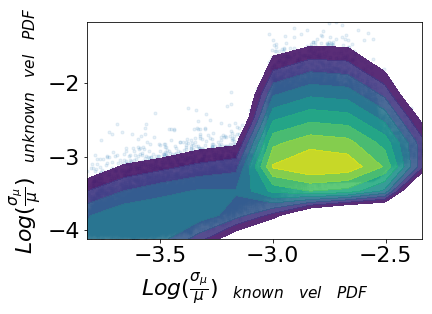

In [74]:
plt.figure()
scatter_contour(lrel,lerr, log_counts=True, plot_args=dict(marker='.', alpha=0.1), contour_args=dict(cmap='viridis',alpha=0.9))
plt.rcParams.update({'font.size':22})
plt.xlabel(r'$Log(\frac{\sigma_{\mu}}{\mu})_{\quad known\quad vel\quad PDF}$')
plt.ylabel(r'$Log(\frac{\sigma_{\mu}}{\mu})_{\quad unknown\quad vel\quad PDF}$')